Running physical reservoir on prediction task...


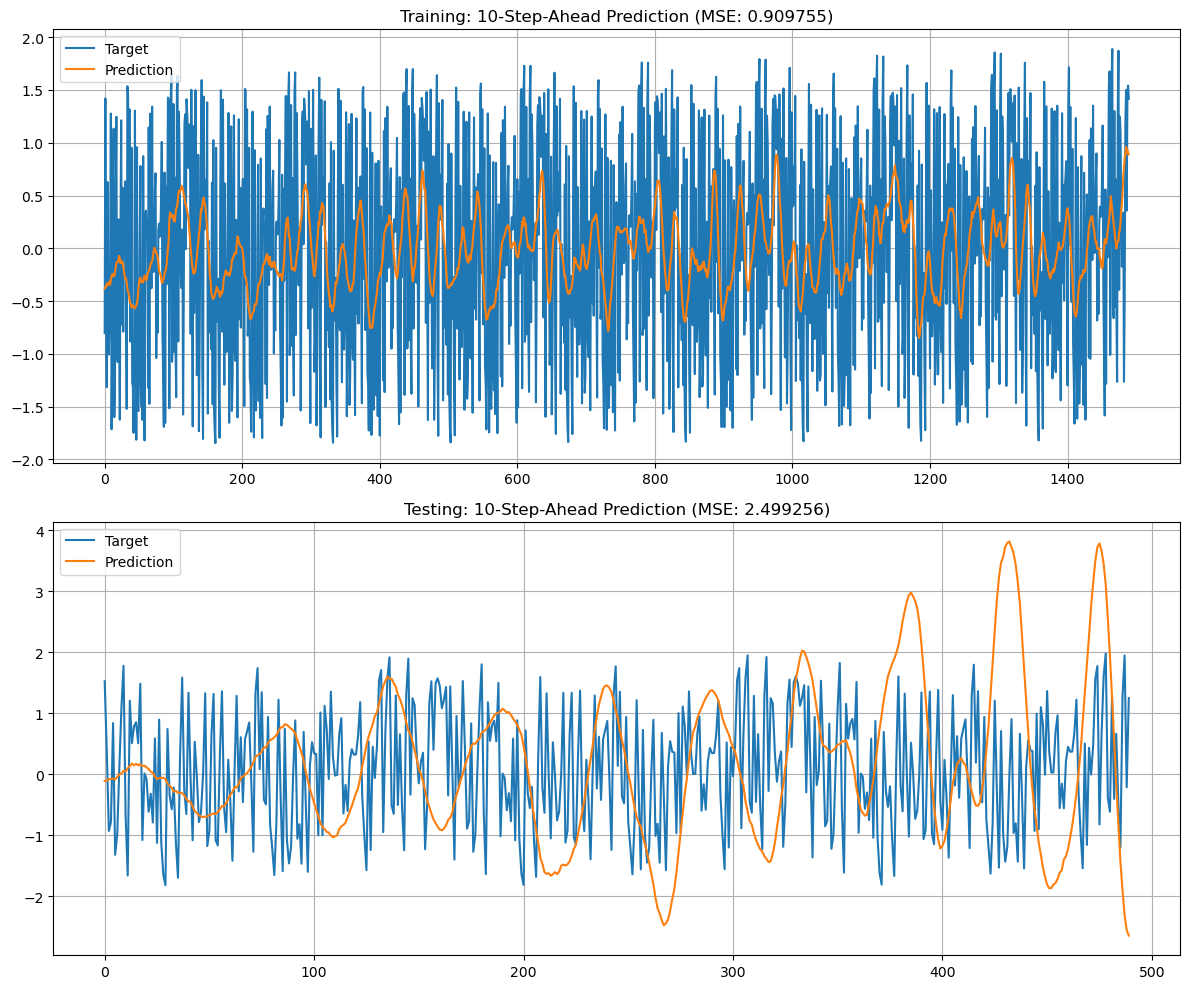

Running physical reservoir on memory task...


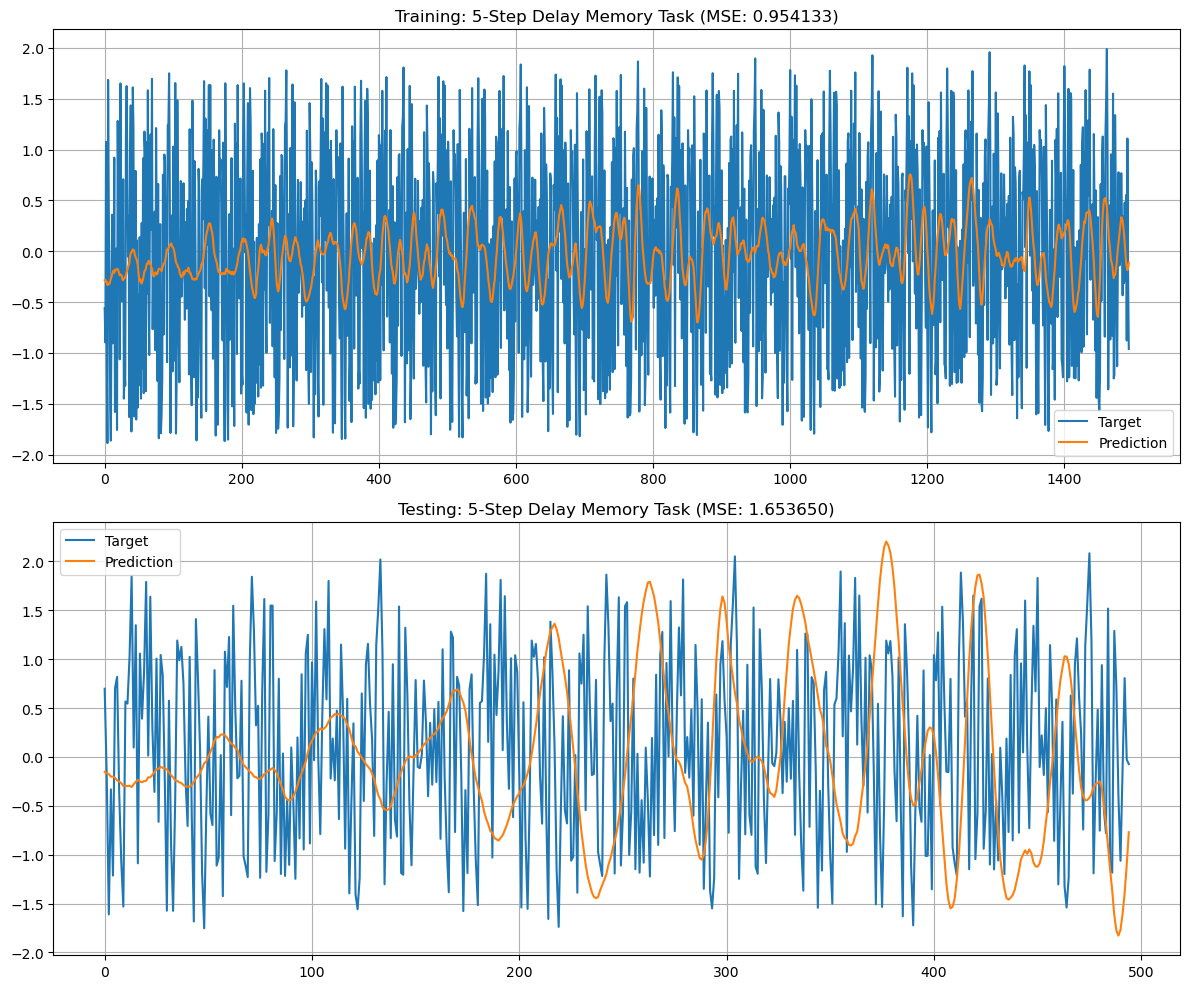

Prediction task test MSE: 2.499256
Memory task test MSE: 1.653650


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

class PhysicalReservoir:
    """
    A simulation of a physical reservoir computing system based on coupled oscillators.
    This model represents a simplified version of a mechanical or electronic physical reservoir.
    """
    
    def __init__(self, n_units=100, coupling_strength=0.1, damping=0.1, 
                 nonlinearity_factor=2.0, noise_level=0.01, dt=0.1):
        """
        Initialize the physical reservoir.
        
        Parameters:
        -----------
        n_units : int
            Number of oscillator units in the reservoir
        coupling_strength : float
            Strength of connections between oscillators
        damping : float
            Damping coefficient for oscillators
        nonlinearity_factor : float
            Strength of nonlinear terms in the oscillator dynamics
        noise_level : float
            Level of noise added to the system
        dt : float
            Time step for simulation
        """
        self.n_units = n_units
        self.coupling_strength = coupling_strength
        self.damping = damping
        self.nonlinearity_factor = nonlinearity_factor
        self.noise_level = noise_level
        self.dt = dt
        
        # Initialize coupling matrix (could represent physical connections in a real system)
        self.coupling_matrix = np.random.randn(n_units, n_units) * coupling_strength / np.sqrt(n_units)
        
        # Input weights (would correspond to how input signals couple to the physical system)
        self.input_weights = np.random.randn(n_units) * 0.5
        
        # Initialize state (position and velocity of oscillators)
        self.positions = np.zeros(n_units)
        self.velocities = np.zeros(n_units)
        
    def _compute_derivatives(self, t, state, input_signal):
        """
        Compute the derivatives for the oscillator system.
        This would represent the actual physics of the system.
        
        Parameters:
        -----------
        t : float
            Current time
        state : array
            Current state of the system [positions, velocities]
        input_signal : float
            Input signal at current time
        
        Returns:
        --------
        array
            Derivatives of state variables
        """
        positions = state[:self.n_units]
        velocities = state[self.n_units:]
        
        # Compute position derivatives (= velocities)
        dpositions = velocities.copy()
        
        # Compute velocity derivatives using physical model:
        # - Spring force (nonlinear): -positions - nonlinearity_factor * positions^3
        # - Damping force: -damping * velocities
        # - Coupling forces: coupling_matrix @ positions
        # - External input: input_weights * input_signal
        
        spring_force = -positions - self.nonlinearity_factor * positions**3
        damping_force = -self.damping * velocities
        coupling_force = self.coupling_matrix @ positions
        input_force = self.input_weights * input_signal
        
        dvelocities = spring_force + damping_force + coupling_force + input_force
        
        return np.concatenate([dpositions, dvelocities])
    
    def update(self, input_signal):
        """
        Update the reservoir state with the given input.
        This simulates the physical evolution of the system.
        
        Parameters:
        -----------
        input_signal : float
            Input value
            
        Returns:
        --------
        array
            Reservoir state (positions of oscillators)
        """
        # Initial state vector [positions, velocities]
        state = np.concatenate([self.positions, self.velocities])
        
        # Simulate the physical system using ODE solver
        # In a real physical reservoir, this would be the actual physical evolution
        result = solve_ivp(
            lambda t, y: self._compute_derivatives(t, y, input_signal),
            [0, self.dt],
            state,
            t_eval=[self.dt]
        )
        
        # Update the state
        state = result.y[:, -1]
        self.positions = state[:self.n_units]
        self.velocities = state[self.n_units:]
        
        # Add some noise (representing thermal fluctuations or other physical noise)
        self.positions += np.random.randn(self.n_units) * self.noise_level
        self.velocities += np.random.randn(self.n_units) * self.noise_level
        
        # Return the observable states of the reservoir
        # In a real physical system, this would be what we can measure
        return self.get_state()
    
    def get_state(self):
        """
        Get the current observable state of the reservoir.
        In a real physical reservoir, this would represent what we can measure.
        
        Returns:
        --------
        array
            Observable reservoir state
        """
        # Combine positions and squares of positions as observable states
        # This represents nonlinear measurements we might take from a physical system
        observable_states = np.concatenate([
            self.positions,
            self.positions**2
        ])
        
        return observable_states
    
    def reset(self):
        """Reset the reservoir to initial conditions"""
        self.positions = np.zeros(self.n_units)
        self.velocities = np.zeros(self.n_units)


def generate_mackey_glass(n_samples, tau=17, beta=0.2, gamma=0.1, n=10, dt=0.1, discard=100):
    """
    Generate Mackey-Glass chaotic time series.
    A common benchmark for reservoir computing.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    tau : int
        Delay parameter (affects chaoticity)
    beta, gamma, n : float
        System parameters
    dt : float
        Time step
    discard : int
        Number of initial samples to discard (transient)
        
    Returns:
    --------
    array
        Mackey-Glass time series
    """
    # Initialize history with random values
    history_length = int(tau/dt) + 1
    x_history = np.random.rand(history_length) * 0.5
    
    # Generate time series
    x = np.zeros(n_samples + discard)
    
    for i in range(n_samples + discard):
        x_tau = x_history[i % history_length]
        x_dot = beta * x_tau / (1 + x_tau**n) - gamma * x_history[(i + 1) % history_length]
        
        # Update history
        x_history[(i + 1) % history_length] += x_dot * dt
        x[i] = x_history[(i + 1) % history_length]
    
    return x[discard:]


def train_test_reservoir(task="prediction", predict_steps=10):
    """
    Train and test a physical reservoir on a time series task.
    
    Parameters:
    -----------
    task : str
        "prediction" (forecast future values) or "memory" (reconstruct past inputs)
    predict_steps : int
        Number of steps to predict ahead (for prediction task)
        or steps to remember back (for memory task)
        
    Returns:
    --------
    dict
        Results including predictions, targets, and error metrics
    """
    # Generate Mackey-Glass time series
    n_samples = 2000
    data = generate_mackey_glass(n_samples)
    
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    
    # Split into train/test
    train_data = data[:1500]
    test_data = data[1500:]
    
    # Create physical reservoir
    reservoir = PhysicalReservoir(n_units=50, coupling_strength=0.2, 
                                 damping=0.05, nonlinearity_factor=1.0)
    
    # Define target based on task
    if task == "prediction":
        train_target = train_data[predict_steps:]
        test_target = test_data[predict_steps:]
        train_inputs = train_data[:-predict_steps]
        test_inputs = test_data[:-predict_steps]
    else:  # Memory task
        train_target = train_data[:-predict_steps]
        test_target = test_data[:-predict_steps]
        train_inputs = train_data[predict_steps:]
        test_inputs = test_data[predict_steps:]
    
    # Run reservoir on training data and collect states
    states = []
    reservoir.reset()
    
    # Warmup (discard initial transient)
    for _ in range(100):
        reservoir.update(0)
    
    # Collect states for training inputs
    for x in train_inputs:
        state = reservoir.update(x)
        states.append(state)
    
    # Convert to numpy array
    states = np.array(states)
    
    # Train readout layer (Ridge Regression)
    # In physical RC, this is typically the only part that needs training
    readout = Ridge(alpha=1e-6)
    readout.fit(states, train_target)
    
    # Evaluate on training data
    train_pred = readout.predict(states)
    train_mse = mean_squared_error(train_target, train_pred)
    
    # Run reservoir on test data
    test_states = []
    reservoir.reset()
    
    # Warmup again
    for _ in range(100):
        reservoir.update(0)
    
    # Collect states for test inputs
    for x in test_inputs:
        state = reservoir.update(x)
        test_states.append(state)
    
    test_states = np.array(test_states)
    
    # Predict using trained readout
    test_pred = readout.predict(test_states)
    test_mse = mean_squared_error(test_target, test_pred)
    
    return {
        "train_inputs": train_inputs,
        "train_target": train_target,
        "train_pred": train_pred,
        "train_mse": train_mse,
        "test_inputs": test_inputs,
        "test_target": test_target,
        "test_pred": test_pred,
        "test_mse": test_mse
    }


def plot_results(results, task_name):
    """
    Plot the results of reservoir computing training and testing.
    
    Parameters:
    -----------
    results : dict
        Results from train_test_reservoir
    task_name : str
        Name of the task for the plot title
    """
    plt.figure(figsize=(12, 10))
    
    # Plot training results
    plt.subplot(2, 1, 1)
    plt.plot(results["train_target"], label="Target")
    plt.plot(results["train_pred"], label="Prediction")
    plt.title(f"Training: {task_name} (MSE: {results['train_mse']:.6f})")
    plt.legend()
    plt.grid(True)
    
    # Plot test results
    plt.subplot(2, 1, 2)
    plt.plot(results["test_target"], label="Target")
    plt.plot(results["test_pred"], label="Prediction")
    plt.title(f"Testing: {task_name} (MSE: {results['test_mse']:.6f})")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Run simulations and visualize results
if __name__ == "__main__":
    # Prediction task
    print("Running physical reservoir on prediction task...")
    prediction_results = train_test_reservoir(task="prediction", predict_steps=10)
    plot_results(prediction_results, "10-Step-Ahead Prediction")
    
    # Memory task
    print("Running physical reservoir on memory task...")
    memory_results = train_test_reservoir(task="memory", predict_steps=5)
    plot_results(memory_results, "5-Step Delay Memory Task")
    
    print(f"Prediction task test MSE: {prediction_results['test_mse']:.6f}")
    print(f"Memory task test MSE: {memory_results['test_mse']:.6f}")